In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from sklearn import preprocessing
import torch.optim as optim

from sklearn.model_selection import train_test_split
import torch.cuda as cuda
from torch.autograd import Variable
import math

from utils import create_dataloader,train
from dataset import EEG
import wandb
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
# Now do your import
import mne
from config import *
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

c:\Users\Pongk\.virtualenvs\EEG-python-MGW7v3UV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# home directory + datasets folder
path = RECORED_PATH
#path = "./dataset/finetune_EEG/"
#path = "/root/EEG_Model/dataset/finetune_EEG/"
#subject to run
#runs = [3,4,5,9,10,11]
#runs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
#runs = [2,3,4,6,8,12,15,17,18,22]
runs = [1,2,3,4,12,13,14,15,16,17]  
subjects = [19]
#recorded eeg class
eeg = EEG(path, subjects, runs)
raw=eeg.data_to_raw()
baseline = (-3, 0)
raw1 = raw.copy()
print("Raw done")


/Users/Pongk/Desktop/Work/mi-project/EEG-python/dataset/recorded_EEG
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Raw done


freqs = np.arange(1, 50, 1)  # Frequencies from 1 to 50 Hz
time_range = (-0.5, 1.0)    # Time range of interest in seconds
# Specify the wavelet(s) and scales
from mne.time_frequency import morlet
wavelets = morlet(250, np.arange(4, 30, 2))
eeg_data = raw1.get_data()
print(eeg_data[0:3,:])
# Compute the CWT
power = mne.time_frequency.tfr.cwt(eeg_data[0:3,:], Ws=wavelets, use_fft=True, mode='same', decim=1)

power.shape

In [3]:
import pandas as pd
eeg_data = raw1.get_data()
print(eeg_data.shape)
print(raw1.times)
timestamps = raw1.times
eeg_data = eeg_data.T
eeg_df = pd.DataFrame(eeg_data, columns=raw.ch_names)
eeg_df['Timestamps'] = timestamps * 250
#print(eeg_df)
#print(eeg_df['STIM MARKERS'].unique())
# left_marker = eeg_df[eeg_df['STIM MARKERS']==1]
# right_marker = eeg_df[eeg_df['STIM MARKERS']==2]
#print(left_marker)
#print(right_marker)
# marker_eeg = [left_marker,right_marker]
# marker_eeg = pd.concat(marker_eeg)
y = eeg_df[eeg_df['STIM MARKERS'].isin([1.0,2.0])]
y = y['STIM MARKERS'].to_numpy().astype(int) - 1
print(y)
#eeg_df = pd.DataFrame(raw1, columns=['C3', 'C4', 'STIM MARKERS'])

(3, 468606)
[0.000000e+00 4.000000e-03 8.000000e-03 ... 1.874412e+03 1.874416e+03
 1.874420e+03]
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [4]:
tg_onset_sth = []
tg_onset_sth.extend(np.where(eeg_df['STIM MARKERS'] == int(1.0))[0])
tg_onset_sth.extend(np.where(eeg_df['STIM MARKERS'] == int(2.0))[0])
#print(tg_onset_sth.extend(np.where(new_eeg == int(1.0))[0]))
#throw = tg_onset_sth.pop()
print(tg_onset_sth)
selected_onset = np.array(tg_onset_sth)
print(range(selected_onset.shape[0]))
onset = raw1.get_data()

print(onset[:,466785 - (1* 250): 466785 + (250 * 5) + (1* 250)].shape)

[821, 5512, 10199, 14884, 19573, 24260, 28945, 33632, 38317, 43004, 47667, 52356, 57042, 61733, 66421, 71109, 75800, 80492, 85183, 89871, 94539, 99226, 103916, 108609, 113298, 117987, 122673, 127359, 132050, 136739, 141407, 146099, 150787, 155473, 160166, 164852, 169541, 174229, 178918, 183604, 188270, 192957, 197642, 202334, 207029, 211718, 216405, 221093, 225784, 230473, 235151, 239839, 244530, 249215, 253903, 258591, 263281, 267972, 272657, 277345, 282012, 286699, 291389, 296078, 300763, 305448, 310136, 314824, 319512, 324199, 328871, 333556, 338242, 342930, 347617, 352303, 356991, 361677, 366366, 371055, 375717, 380402, 385092, 389780, 394468, 399156, 403842, 408530, 413215, 417903, 422566, 427252, 431939, 436630, 441318, 446005, 450693, 455384, 460071, 464759, 3165, 7856, 12542, 17228, 21916, 26603, 31289, 35975, 40660, 45347, 50013, 54699, 59387, 64078, 68764, 73455, 78144, 82840, 87525, 92214, 96882, 101571, 106264, 110953, 115644, 120330, 125017, 129705, 134394, 139082, 143750,

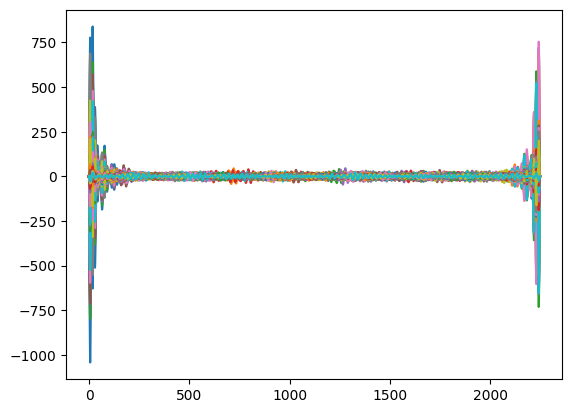

(400, 1750)


In [5]:
dura_sam = 250 * 5
trialofintereted = []
padding = 3*250
offset = 3 * 250
offset2 = 1 * 250
raw_pad = raw1.get_data()
padded = np.empty([2, dura_sam+(2*padding)+(2*offset)])
iir_param = dict(order=6, ftype='butter', output='sos')

for trials in range(selected_onset.shape[0]):
    onset_idx = selected_onset[trials]
    #fist is channle second is selected time samples(1250)
    temp = raw_pad[:,onset_idx - offset :onset_idx+dura_sam + offset2]
    #print(temp -= mean)
    #print(temp.shape)
    #print(padded.shape)
    # for ch in range(temp.shape[0]):
    #     #print("channel" + str(ch))
    #     if ch == 2:
    #         break
    #     #print(temp[ch, :].shape)
    #     padded[ch, :] = np.pad(temp[ch, :], (padding, padding), mode='mean')
    #     #print("After padded")
    #     #print(padded.shape)
    filtered_data = mne.filter.filter_data(temp[0:2,:], sfreq=250, l_freq=8, h_freq=13,method='iir',iir_params=iir_param,verbose=False) # bandpass
    filtered_temp = mne.filter.notch_filter(filtered_data, Fs=250, freqs=50, verbose=False) # notch
    #print(filtered_temp.shape)
    #filtered_temp = preprocessing.normalize(filtered_temp)
    plt.plot(filtered_temp[0,:])
    filtered = filtered_temp[:,offset2:offset+dura_sam]
    trialofintereted.append(filtered)
plt.show()
print(np.concatenate(trialofintereted).shape)
temp = [t[np.newaxis, ...] for t in trialofintereted]
data = np.concatenate(temp)

<class 'numpy.ndarray'>
(200, 2, 1750)


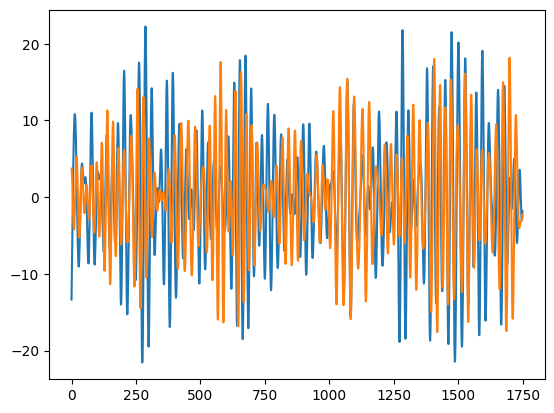

In [6]:
print(type(data))
print(data.shape)

for ch in range(int(data.shape[1])):
    plt.plot(data[0,ch,:])
    
plt.show()

In [7]:
#manual baseline correction
baseline = []

for e in range(data.shape[0]):
    avg_epoch = np.mean(data[e,:,:(250*2)], axis=1)
    baseline.append(avg_epoch)
baseline = np.asarray(baseline)

In [8]:
data[0,0,:]

array([-13.34140209, -11.04498427,  -8.46458317, ...,  -3.02762243,
        -2.65338801,  -1.80298894])

In [9]:
for e in range(data.shape[0]):
    for c in range(int(data.shape[1])):
        data[e,c,:] = data[e,c,:] - baseline[e,c]

In [10]:
data[0,0,:]

array([-13.30769816, -11.01128035,  -8.43087925, ...,  -2.9939185 ,
        -2.61968408,  -1.76928501])

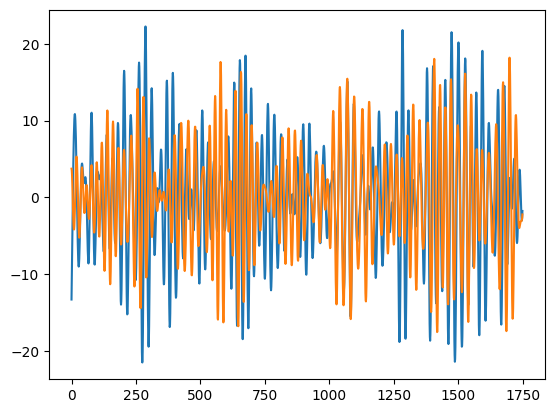

In [11]:

for ch in range(int(data.shape[1])):
    plt.plot(data[0,ch,:])
    
plt.show()

In [ ]:
#manual csp
X = eeg.apply_CSP(data,y)

In [ ]:
print(X.shape)
print(y)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pickle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print('Train size',X_train.shape, y_train.shape)
print('Test size',X_test.shape, y_test.shape)
print(y_train)
print(y_test)

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Test acc: ", accuracy_score(y_test, y_pred))

pkl_filename = "svm_S19_-2-5.pk"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)


confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
mean_squared_error(y_test, y_pred)

In [ ]:
loaded_model = pickle.load(open("svm_S17_-2-5.pk", 'rb'))
result = loaded_model.predict(X_test)
print("Test acc: ", accuracy_score(y_test, result))
ConfusionMatrixDisplay.from_predictions(y_test, result)
print(result)

In [ ]:
# apply notch filter 
raw=raw.notch_filter([50])

#raw.plot_psd(fmax=20)

In [ ]:
iir_param = dict(order=5, ftype='butter', output='sos')
raw=raw.filter(8,14, method='fir', verbose=20)
#raw=raw.filter(8,14,method = 'iir',iir_params=iir_param,phase='zero')
print("Filter done")

#raw.plot(duration=9)

In [ ]:
epochs=eeg.epochs(raw1,tmin=-3,tmax=5,baseline=(-3,0))
epochs = epochs.filter(8,14,method='fir', verbose=20)
#X = X[:, :,np.newaxis,:]
X, y = eeg.get_X_y(epochs)



In [ ]:
epochs._data.shape
for ch in range(int(epochs._data.shape[1])):
    plt.plot(epochs._data[0,ch,:])
    
plt.show()

In [ ]:
# Define wavelet and decomposition level
wavelet = 'db4'  # Choose a wavelet
level = 4       # Choose a decomposition level

# Perform Wavelet Packet Decomposition
coeffs = []
for epoch_data in epochs.get_data():
    channel_coeffs = []
    for channel in epoch_data:
        coeffs_per_channel = pywt.wavedec(channel, wavelet, level=level)
        channel_coeffs.extend(coeffs_per_channel)
    coeffs.append(channel_coeffs)
flattened_coeffs = [np.concatenate(channel_coeffs) for channel_coeffs in coeffs]

# Reshape the coefficients for feature extraction
# Convert data to NumPy array
X = np.array(flattened_coeffs)
y = np.array(y)
print(X.shape)